In [ ]:
# in this file Serikova Karina builds scoring model using XGBoost algorithm

In [1]:
import pandas as pd
import numpy as np
import scorecardpy as sc

%pylab inline
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import statsmodels.api as sm

import lightgbm
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier, plot_importance

import pickle
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from matplotlib import rc
rc('font', family = 'Verdana')

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_excel(r'C:\Users\Alfa\Desktop\1.xlsx')
print(data.shape)
for column_name in data.columns:
    print(column_name, ' - ', data[column_name].dtype)

(30000, 25)
ID  -  int64
LIMIT_BAL  -  int64
SEX  -  object
EDUCATION  -  object
MARRIAGE  -  object
AGE  -  int64
PAY_0  -  int64
PAY_2  -  int64
PAY_3  -  int64
PAY_4  -  int64
PAY_5  -  int64
PAY_6  -  int64
BILL_AMT1  -  int64
BILL_AMT2  -  int64
BILL_AMT3  -  int64
BILL_AMT4  -  int64
BILL_AMT5  -  int64
BILL_AMT6  -  int64
PAY_AMT1  -  int64
PAY_AMT2  -  int64
PAY_AMT3  -  int64
PAY_AMT4  -  int64
PAY_AMT5  -  int64
PAY_AMT6  -  int64
target  -  int64


In [3]:
data.drop(columns = ['ID'], inplace = True)

In [4]:
data.fillna(-9999, inplace=True)

In [5]:
text_features = [col for col in data.columns if data[col].dtype == 'object']
text_data = pd.get_dummies(data[text_features], prefix = text_features, drop_first = True)

numeric_features = [col for col in data.columns if data[col].dtype != 'object']
data_numeric = pd.concat([data[numeric_features], text_data], axis = 1)

print(data.shape, data_numeric.shape)
data.head(5)

(30000, 24) (30000, 31)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,20000,female,bachelor,married,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,female,bachelor,single,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,female,bachelor,single,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,female,bachelor,married,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,male,bachelor,married,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
data_numeric

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,SEX_male,EDUCATION_bachelor,EDUCATION_college,EDUCATION_doctoral studies,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_magistracy,MARRIAGE_divorced,MARRIAGE_married,MARRIAGE_single
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,0,1,0,0,0,0,0,0,1,0
1,120000,26,-1,2,0,0,0,2,2682,1725,...,0,1,0,0,0,0,0,0,0,1
2,90000,34,0,0,0,0,0,0,29239,14027,...,0,1,0,0,0,0,0,0,0,1
3,50000,37,0,0,0,0,0,0,46990,48233,...,0,1,0,0,0,0,0,0,1,0
4,50000,57,-1,0,-1,0,0,0,8617,5670,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,39,0,0,0,0,0,0,188948,192815,...,1,0,0,0,0,1,0,0,1,0
29996,150000,43,-1,-1,-1,-1,0,0,1683,1828,...,1,0,0,0,0,1,0,0,0,1
29997,30000,37,4,3,2,-1,0,0,3565,3356,...,1,1,0,0,0,0,0,0,0,1
29998,80000,41,1,-1,0,0,0,-1,-1645,78379,...,1,0,0,0,0,1,0,0,1,0


In [8]:
from sklearn.metrics import roc_auc_score

In [9]:
from sklearn.model_selection import StratifiedKFold

In [10]:
def individual_gini(v):
    if data[v].dtypes == 'O':
        x = pd.get_dummies(data[v]).values
        obvious_gini = 0
    else:
        x = data[v].values.reshape(-1, 1)
        obvious_gini = abs(roc_auc_score(data.target.values,x)*2-1)
    
    parameters = {'min_weight_fraction_leaf':[0.01, 0.025, 0.05, 0.1]}
    dt = DecisionTreeClassifier(random_state=123)
    kfolds = StratifiedKFold(4)
    clf = GridSearchCV(dt, parameters, cv=kfolds.split(x, data.target.values), scoring='roc_auc')
    clf.fit(x, data.target.values)
    true_gini = abs(clf.best_score_*2-1)
    return max(obvious_gini, true_gini)

In [11]:
df_vars_ginis = pd.DataFrame(data = data.columns.values, columns = ['vars'])
df_vars_ginis['gini'] = df_vars_ginis['vars'].apply(individual_gini)

print(df_vars_ginis)

         vars      gini
0   LIMIT_BAL  0.236761
1         SEX  0.047092
2   EDUCATION  0.080282
3    MARRIAGE  0.037808
4         AGE  0.066473
5       PAY_0  0.421178
6       PAY_2  0.297225
7       PAY_3  0.266843
8       PAY_4  0.238613
9       PAY_5  0.218534
10      PAY_6  0.203236
11  BILL_AMT1  0.059442
12  BILL_AMT2  0.050444
13  BILL_AMT3  0.050912
14  BILL_AMT4  0.050309
15  BILL_AMT5  0.072859
16  BILL_AMT6  0.064760
17   PAY_AMT1  0.225657
18   PAY_AMT2  0.210601
19   PAY_AMT3  0.193110
20   PAY_AMT4  0.181013
21   PAY_AMT5  0.161249
22   PAY_AMT6  0.169705
23     target  1.000000


In [12]:
categorical_vars = []
numeric_vars = []

for col in data.columns:
    if data[col].nunique() < 4 or data[col].dtypes == 'O':
        categorical_vars.append(col)
    else:
        numeric_vars.append(col)

In [13]:
print('categorical: ', categorical_vars)
print(' ')
print('numerical: ', numeric_vars)

categorical:  ['SEX', 'EDUCATION', 'MARRIAGE', 'target']
 
numerical:  ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [14]:
from scipy import stats

In [15]:
sample_size = data.shape[0]

def cramers_v(col1, col2):
    confusion_matrix = pd.crosstab(data[col1], data[col2])
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    
    if(sample_size * (min(confusion_matrix.shape)-1) != 0):
        return np.sqrt(chi2/(sample_size * (min(confusion_matrix.shape)-1)))
    else:
        return 0

In [16]:
df_dat_corrs = pd.DataFrame(columns = ['var1', 'var2'])

counter = 0
for idx, col1 in enumerate(categorical_vars):
    for col2 in categorical_vars[idx+1:]:
        df_dat_corrs.loc[counter] = [col1, col2]
        counter += 1
df_dat_corrs['corr'] = df_dat_corrs.apply(lambda row: cramers_v(row['var1'], row['var2']), axis = 1)

In [17]:
df_dat_corrs.sort_values(by = ['corr'], ascending = False, inplace = True)

In [18]:
to_drop_cat = []
log = []
for i in df_dat_corrs[df_dat_corrs['corr'] > 0.7]:
    v1 = i[0]
    v2 = i[1]
    
    if v1 in to_drop_cat or v2 in to_drop_cat or v1 not in data.columns.values or v2 not in data.columns.values:
        continue
        
    if df_vars_ginis[df_vars_ginis['vars'] == v1].gini.values > df_vars_ginis[df_vars_ginis['vars'] == v2].gini.values:
        var_to_drop = v2
    else:
        var_to_drop = v1
        
    var_to_leave = v2 if(v1 == var_to_drop) else v1
    
    log.append([var_to_drop, var_to_leave, i[2]])
    to_drop_cat.append(var_to_drop)

print(len(to_drop_cat), 'variables dropped')
variables2 = [i for i in categorical_vars if i not in to_drop_cat]
print(len(variables2), 'variables left')

0 variables dropped
4 variables left


In [19]:
df_numeric = data[numeric_vars]
df_numeric.replace(-9999, NaN, inplace = True)
df_numeric.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,120000,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [20]:
##%%time
df_num_corrs = df_numeric.corr()

(20, 20)


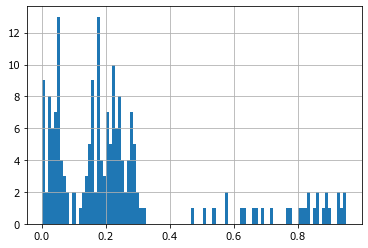

In [21]:
df_num_corrs = df_num_corrs.abs()
print(df_num_corrs.shape)

correlations = df_num_corrs.where(np.triu(
    np.ones(df_num_corrs.shape), k=1
).astype(np.bool)).stack().sort_values(ascending = False)

correlations.hist(bins = 100)

In [22]:
to_drop_num = []
log = []
for i in correlations[correlations > 0.7].index:
    v1 = i[0]
    v2 = i[1]
    
    if v1 in to_drop_num or v2 in to_drop_num:
        continue
        
    if df_vars_ginis[df_vars_ginis['vars'] == v1].gini.values > df_vars_ginis[df_vars_ginis['vars'] == v2].gini.values:
        var_to_drop = v2
    else:
        var_to_drop = v1
        
    var_to_leave = v2 if(v1 == var_to_drop) else v1
    
    log.append([var_to_drop, var_to_leave, correlations[i]])
    to_drop_num.append(var_to_drop)

print(len(to_drop_num), 'variables dropped')
variables2 = [i for i in numeric_vars if i not in to_drop_num]
print(len(variables2), 'variables left')

8 variables dropped
12 variables left


In [23]:
data.drop(to_drop_cat, axis = 1, inplace = True)
data.drop(to_drop_num, axis = 1, inplace = True)
print(data.shape)

(30000, 16)


In [24]:
categorical_vars1 = []
numeric_vars1 = []

for col in data.columns:
    if data[col].nunique() < 4 or data[col].dtypes == 'O':
        categorical_vars1.append(col)
    else:
        numeric_vars1.append(col)
        
print('categorical: ', categorical_vars1, '\n')
print('numerical: ', numeric_vars1)


categorical:  ['SEX', 'EDUCATION', 'MARRIAGE', 'target'] 

numerical:  ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_6', 'BILL_AMT5', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [25]:
dt_s =sc.var_filter(data[categorical_vars1], y = 'target')
dt_s.replace(-9999, NaN, inplace = True)
#dt_s.replace(NaN, '-9999', inplace = True)
print(dt_s)

[INFO] filtering variables ...
         EDUCATION  target
0         bachelor       1
1         bachelor       1
2         bachelor       0
3         bachelor       0
4         bachelor       0
...            ...     ...
29995  high school       0
29996  high school       0
29997     bachelor       1
29998  high school       1
29999     bachelor       1

[30000 rows x 2 columns]


In [26]:
bins = sc.woebin(dt_s, y='target', x=['EDUCATION'])
#breaks_adj = sc.woebin_adj(dt_s, 'target', bins)

[INFO] creating woe binning ...


In [27]:
dt_s['EDUCATION'].unique()

array(['bachelor', 'graduate school', 'high school', 'magistracy',
       'college', 'doctoral studies', nan], dtype=object)

In [28]:
dt_s['target'].unique()

array([1, 0], dtype=int64)

In [29]:
bins

{'EDUCATION':     variable                                                bin  count  \
 0  EDUCATION                                            missing     14   
 1  EDUCATION  college%,%magistracy%,%doctoral studies%,%grad...  11039   
 2  EDUCATION                                           bachelor  14030   
 3  EDUCATION                                        high school   4917   
 
    count_distr   good   bad   badprob       woe    bin_iv  total_iv  \
 0     0.000467     14     0  0.000000 -1.485866  0.000689  0.024578   
 1     0.367967   8970  2069  0.187426 -0.208269  0.015033  0.024578   
 2     0.467667  10700  3330  0.237349  0.091280  0.003995  0.024578   
 3     0.163900   3680  1237  0.251576  0.168328  0.004860  0.024578   
 
                                               breaks  is_special_values  
 0                                            missing               True  
 1  college%,%magistracy%,%doctoral studies%,%grad...              False  
 2                     

In [66]:
breaks_adj = sc.woebin_adj(dt_s, "target", bins)

ValueError: Wrong number of items passed 3, placement implies 1

In [30]:
bins_adj = sc.woebin(dt_s, y = 'target', breaks_list = bins)
#print(breaks_adj)

[INFO] creating woe binning ...


In [31]:
bins_adj

{'EDUCATION':     variable      bin  count  count_distr   good   bad   badprob       woe  \
 0  EDUCATION  missing     14     0.000467     14     0  0.000000 -1.485866   
 1  EDUCATION  missing  29986     0.999533  23350  6636  0.221303  0.000464   
 
          bin_iv  total_iv   breaks  is_special_values  
 0  6.888581e-04  0.000689  missing               True  
 1  2.150104e-07  0.000689  missing              False  }

In [32]:
dt_s_woe = sc.woebin_ply(dt_s, bins)
dt_s_woe.drop(columns=['target'], inplace = True)

[INFO] converting into woe values ...


In [33]:
data2=pd.concat([data, dt_s_woe], axis = 1)
data2.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_6,BILL_AMT5,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target,EDUCATION_woe
0,20000,female,bachelor,married,24,2,2,-2,0,0,689,0,0,0,0,1,0.09128
1,120000,female,bachelor,single,26,-1,2,2,3455,0,1000,1000,1000,0,2000,1,0.09128
2,90000,female,bachelor,single,34,0,0,0,14948,1518,1500,1000,1000,1000,5000,0,0.09128
3,50000,female,bachelor,married,37,0,0,0,28959,2000,2019,1200,1100,1069,1000,0,0.09128
4,50000,male,bachelor,married,57,-1,0,0,19146,2000,36681,10000,9000,689,679,0,0.09128


In [34]:
list(data2.columns)

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_6',
 'BILL_AMT5',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'target',
 'EDUCATION_woe']

In [35]:
data2['EDUCATION_woe'].unique()

array([ 0.09127995, -0.20826889,  0.16832773, -1.48586646])

In [36]:
data2.drop(columns=['MARRIAGE', 'SEX'], inplace = True)

In [37]:
data2.drop(columns=['EDUCATION'], inplace = True)

In [38]:
all_x_variables = data2.columns.difference(['target']).tolist()
X = data2[all_x_variables]
y = data2['target']

In [39]:
print([i for i in data2 if i!='target'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    #stratify = y,
                                                   random_state = 2,
                                                   test_size = 0.25)

print(X_train.shape, X_test.shape)
print(y_train.mean(), y_test.mean())

['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_6', 'BILL_AMT5', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'EDUCATION_woe']
(22500, 13) (7500, 13)
0.2212 0.2212


In [40]:
X.columns

Index(['AGE', 'BILL_AMT5', 'EDUCATION_woe', 'LIMIT_BAL', 'PAY_0', 'PAY_2',
       'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6'],
      dtype='object')

In [42]:
def score(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    XGB = XGBClassifier(**params)
    XGB.fit(X_train[X.columns], y_train)
    tr_loss = 1-roc_auc_score(y_train, XGB.predict_proba(X_train[X.columns])[:,1])*2
    te_loss = 1-roc_auc_score(y_test, XGB.predict_proba(X_test[X.columns])[:,1])*2
    return{'loss':te_loss, 'status':STATUS_OK, 'tr_loss':tr_loss}

short_trials_xgb = Trials()
space = {
    'learning_rate': hp.quniform('learning_rate', 0.025, 0.1, 0.005),
    'max_depth' : hp.quniform('max_depth', 2, 3, 1),
    'n_estimators' : hp.choice('n_estimators', range(100, 301)),
    'min_child_weight' : hp.choice('min_child_weight', [0.005, 0.1, 0.15, 0.2]),
    'subsample' : hp.uniform('subsample', 0.5, 1)
}

fmin(score, space, algo = tpe.suggest, trials = short_trials_xgb, max_evals = 300)

100%|█████████████████████████████████████████████| 300/300 [12:48<00:00,  2.56s/trial, best loss: -0.5664897769596333]


{'learning_rate': 0.09,
 'max_depth': 3.0,
 'min_child_weight': 3,
 'n_estimators': 165,
 'subsample': 0.9103565059682673}

In [43]:
#%%time
temp_vars=data2
temp_vars = [i for i in temp_vars if i!='target']
xgbc=XGBClassifier()
res = []
while len(temp_vars)>8:
    xgbc.fit(X_train[temp_vars], y_train)
    train_gini = roc_auc_score(y_train, xgbc.predict_proba(X_train[temp_vars])[:,1])*2-1
    test_gini = roc_auc_score(y_test, xgbc.predict_proba(X_test[temp_vars])[:,1])*2-1
    res.append([len(temp_vars), train_gini, test_gini])
    
    imp = pd.Series(dict(zip(temp_vars, xgbc.feature_importances_))).sort_values(ascending=False)
    temp_vars=[i for i in temp_vars if imp.loc[i]>0]
    imp=imp[imp>0]
    temp_vars=[i for i in temp_vars if i in imp[:-1].index.values]
    print(len(temp_vars))
    print([train_gini, test_gini])
    
xgbc.fit(X_train[temp_vars], y_train)
res.append([len(temp_vars),
           roc_auc_score(y_train, xgbc.predict_proba(X_train[temp_vars])[:,1])*2-1,
           roc_auc_score(y_test, xgbc.predict_proba(X_test[temp_vars])[:,1])*2-1
           ])

12
[0.8596737367625829, 0.5208921490835243]
11
[0.8348007981610688, 0.5265264902681766]
10
[0.8295137372826948, 0.5278807424269771]
9
[0.8278497226028751, 0.5255073182556556]
8
[0.8329298394139031, 0.5336274649726698]


['LIMIT_BAL',
 'PAY_0',
 'PAY_2',
 'PAY_6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4']

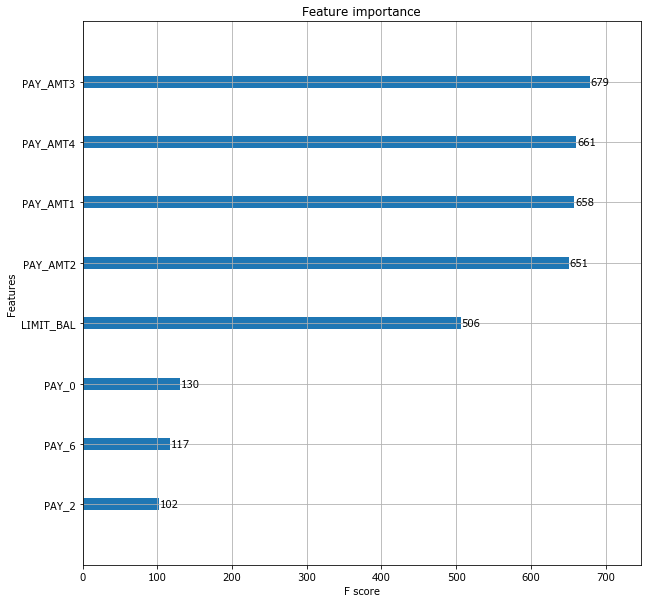

In [44]:
pylab.rcParams['figure.figsize']=(10,10)
plot_importance(xgbc)
temp_vars

In [ ]:
{'learning_rate': 0.09,
 'max_depth': 3.0,
 'min_child_weight': 3,
 'n_estimators': 165,
 'subsample': 0.9103565059682673}

In [45]:
lgbm = lightgbm.LGBMClassifier(learning_rate=0.09, max_depth=3, min_child_weight=0.2, n_estimators=165, subsample=0.9103565059682673)

cols = ['LIMIT_BAL',
 'PAY_0',
 'PAY_2',
 'PAY_6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4']

candid = list(X_train.columns.difference(temp_vars))
res = []
while len(candid)>0:
    temp_ginis = []
    for i in candid:
        lgbm.fit(X_train[cols+[i]], y_train)
        Proba_test = lgbm.predict_proba(X_test[cols+[i]])[:,1]
        temp_ginis.append(roc_auc_score(y_test, Proba_test)*2-1)
    best_candid = candid[np.argmax(temp_ginis)]
    best_gini = np.max(temp_ginis)
    print(best_candid, best_gini)
    res.append({'variable':best_candid, 'test_gini':best_gini})
    cols.append(best_candid)
    candid = [i for i in candid if i!=best_candid]

PAY_AMT6 0.5585607507941772
BILL_AMT5 0.5613167256591414
AGE 0.5631247343326296
EDUCATION_woe 0.5647461631156117
PAY_AMT5 0.5628076104368747


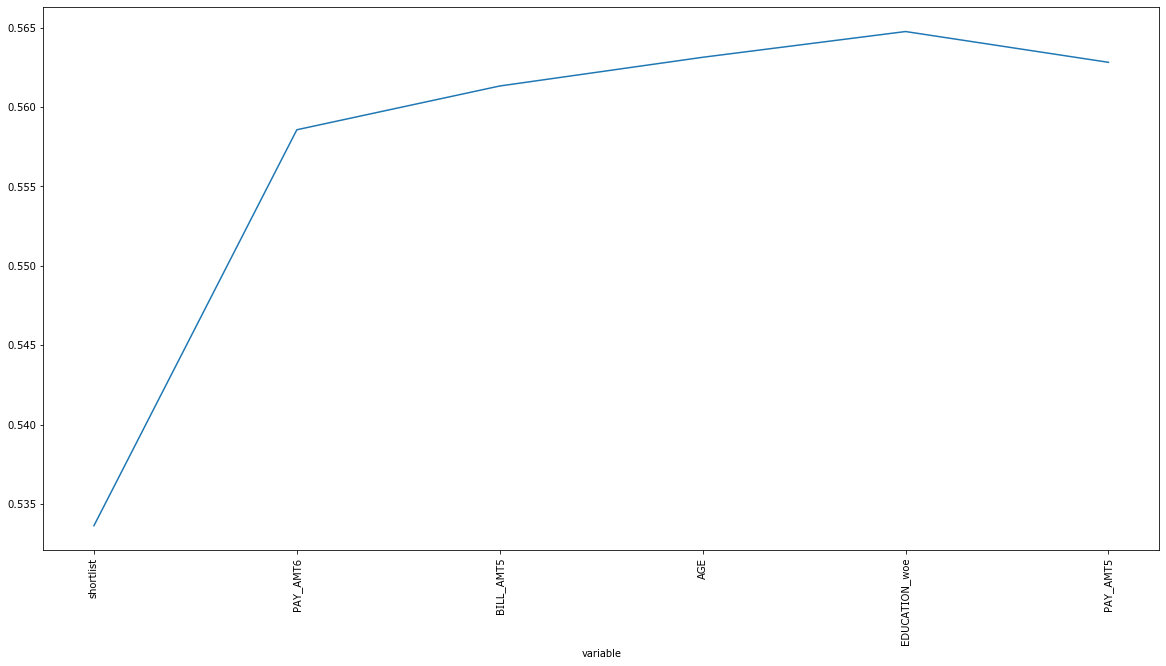

In [46]:
forw = pd.DataFrame([{'variable':'shortlist','test_gini':0.5336274649726698}]+res)
forw.index=forw.variable
forw.test_gini.plot(rot=90, figsize=(20,10), xticks=np.arange(len(forw)))

In [47]:
cols2 = ['LIMIT_BAL',
 'PAY_0',
 'PAY_2',
 'PAY_6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
        'BILL_AMT5',
'PAY_AMT6' ,
'AGE',
'PAY_AMT5' ,
        'EDUCATION_woe']

In [48]:
def score(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    XGB = XGBClassifier(**params)
    XGB.fit(X_train[cols2], y_train)
    tr_loss = 1-roc_auc_score(y_train, XGB.predict_proba(X_train[cols2])[:,1])*2
    te_loss = 1-roc_auc_score(y_test, XGB.predict_proba(X_test[cols2])[:,1])*2
    return{'loss':te_loss, 'status':STATUS_OK, 'tr_loss':tr_loss}

short_trials_xgb = Trials()
space = {
    'learning_rate': hp.quniform('learning_rate', 0.025, 0.1, 0.005),
    'max_depth' : hp.quniform('max_depth', 2, 3, 1),
    'n_estimators' : hp.choice('n_estimators', range(100, 301)),
    'min_child_weight' : hp.choice('min_child_weight', [0.005, 0.1, 0.15, 0.2]),
    'subsample' : hp.uniform('subsample', 0.5, 1)
}

fmin(score, space, algo = tpe.suggest, trials = short_trials_xgb, max_evals = 300)

100%|█████████████████████████████████████████████| 300/300 [12:43<00:00,  2.54s/trial, best loss: -0.5660694562217841]


{'learning_rate': 0.065,
 'max_depth': 3.0,
 'min_child_weight': 2,
 'n_estimators': 99,
 'subsample': 0.8763235295258086}

0.5727348714547456 0.5615413851843805


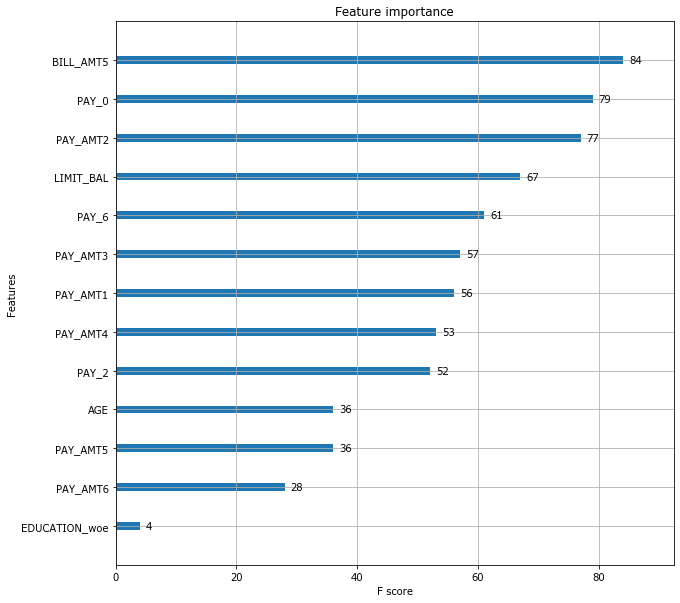

In [49]:
xgbc2 = XGBClassifier(learning_rate=0.065, max_depth=3, min_child_weight=0.15, n_estimators=99, subsample=0.8763235295258086)
xgbc2.fit(X_train[cols2], y_train)
train_gini2 = roc_auc_score(y_train, xgbc2.predict_proba(X_train[cols2])[:,1])*2-1
test_gini2= roc_auc_score(y_test, xgbc2.predict_proba(X_test[cols2])[:,1])*2-1
print(train_gini2,test_gini2)
pylab.rcParams['figure.figsize']=(10,10)
plot_importance(xgbc2)

In [51]:
cols3 = ['LIMIT_BAL',
 'PAY_0',
 'PAY_2',
 'PAY_6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
        'BILL_AMT5',
'PAY_AMT6' ,
'AGE',
'PAY_AMT5']

In [53]:
def score(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    XGB = XGBClassifier(**params)
    XGB.fit(X_train[cols3], y_train)
    tr_loss = 1-roc_auc_score(y_train, XGB.predict_proba(X_train[cols3])[:,1])*2
    te_loss = 1-roc_auc_score(y_test, XGB.predict_proba(X_test[cols3])[:,1])*2
    return{'loss':te_loss, 'status':STATUS_OK, 'tr_loss':tr_loss}

short_trials_xgb = Trials()
space = {
    'learning_rate': hp.quniform('learning_rate', 0.025, 0.1, 0.005),
    'max_depth' : hp.quniform('max_depth', 2, 3, 1),
    'n_estimators' : hp.quniform('n_estimators', 100, 301, 1),
    'min_child_weight' : hp.choice('min_child_weight', [0.005, 0.1, 0.15, 0.2]),
    'subsample' : hp.uniform('subsample', 0.5, 1)
}

fmin(score, space, algo = tpe.suggest, trials = short_trials_xgb, max_evals = 300)

100%|█████████████████████████████████████████████| 300/300 [15:14<00:00,  3.05s/trial, best loss: -0.5662887495112341]


{'learning_rate': 0.045,
 'max_depth': 3.0,
 'min_child_weight': 0,
 'n_estimators': 284.0,
 'subsample': 0.61154392469923}

0.6037193334387545 0.5662887495112341


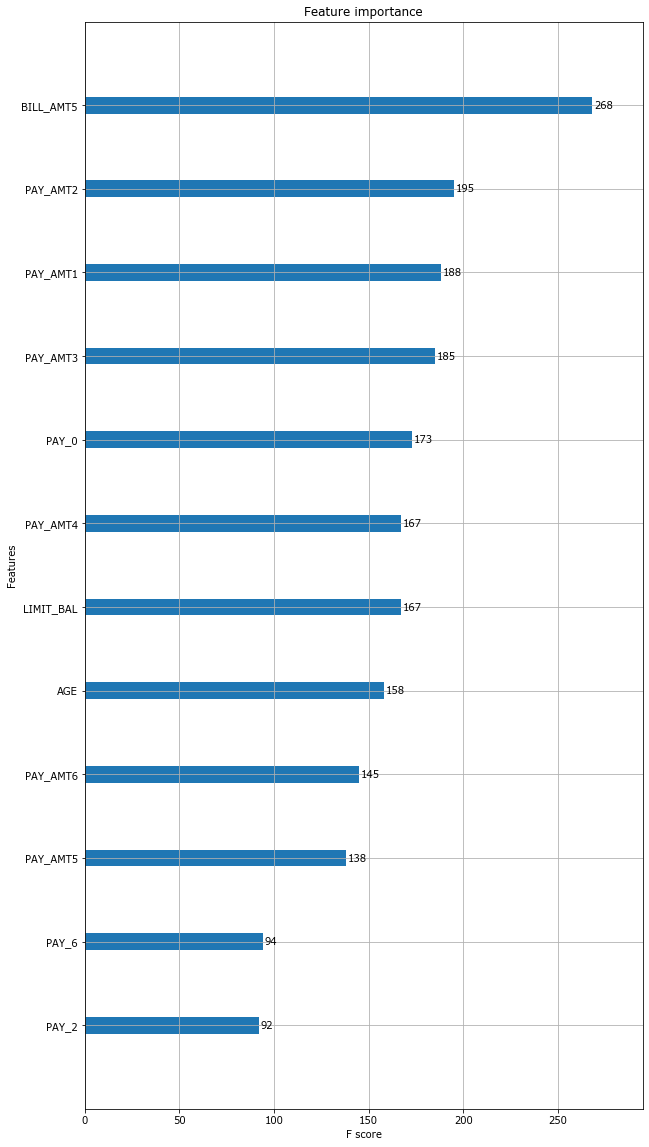

In [54]:
xgbc4 = XGBClassifier(learning_rate=0.045, max_depth=3, min_child_weight=0.005, n_estimators=284, subsample=0.61154392469923)
xgbc4.fit(X_train[cols3], y_train)
train_gini4 = roc_auc_score(y_train, xgbc4.predict_proba(X_train[cols3])[:,1])*2-1
test_gini4= roc_auc_score(y_test, xgbc4.predict_proba(X_test[cols3])[:,1])*2-1
print(train_gini4,test_gini4)
pylab.rcParams['figure.figsize']=(10,20)
plot_importance(xgbc4)

In [55]:
%%time
i = 0
res = []

for md in [2]:
    for n_est in range(100, 301, 10):
        for lr in [0.025, 0.05, 0.075, 0.1]:
            for mcw in [0.005, 0.1, 0.15, 0.2]:
                for subsample in [0.2, 0.5, 0.7]:
                    xgbc = XGBClassifier(n_estimators = n_est,
                                        max_depth = md,
                                        learning_rate = lr,
                                        seed = 1,
                                        min_child_weight = mcw, 
                                        subsample = subsample)
                    xgbc.fit(X_train[cols3], y_train)
                    train_gini = roc_auc_score(y_train, xgbc.predict_proba(X_train[cols3])[:,1])*2-1
                    test_gini = roc_auc_score(y_test, xgbc.predict_proba(X_test[cols3])[:,1])*2-1
                    res.append({
                        'max_depth':md,
                        'n_estimators':n_est,
                        'learning_rate':lr,
                        'min_child_weight':mcw,
                        'subsample':subsample,
                        'train':train_gini,
                        'test':test_gini
                    })
                    
                    print(i, md, n_est, lr, mcw, subsample, train_gini, test_gini)
                    i += 1

0 2 100 0.025 0.005 0.2 0.5336463499947732 0.5413186224170992
1 2 100 0.025 0.005 0.5 0.5343209821504893 0.5389215661689379
2 2 100 0.025 0.005 0.7 0.5328331588790718 0.5377492500427494
3 2 100 0.025 0.1 0.2 0.5336463499947732 0.5413186224170992
4 2 100 0.025 0.1 0.5 0.5343209821504893 0.5389215661689379
5 2 100 0.025 0.1 0.7 0.5328331588790718 0.5377492500427494
6 2 100 0.025 0.15 0.2 0.5336463499947732 0.5413186224170992
7 2 100 0.025 0.15 0.5 0.5343209821504893 0.5389215661689379
8 2 100 0.025 0.15 0.7 0.5328331588790718 0.5377492500427494
9 2 100 0.025 0.2 0.2 0.5336463499947732 0.5413186224170992
10 2 100 0.025 0.2 0.5 0.5343209821504893 0.5389215661689379
11 2 100 0.025 0.2 0.7 0.5328331588790718 0.5377492500427494
12 2 100 0.05 0.005 0.2 0.5469578023870141 0.5539591004083602
13 2 100 0.05 0.005 0.5 0.5469200323428076 0.5504105737961136
14 2 100 0.05 0.005 0.7 0.5464847709954865 0.5487623138341866
15 2 100 0.05 0.1 0.2 0.5469578023870141 0.5539591004083602
16 2 100 0.05 0.1 0.5 0

135 2 120 0.1 0.1 0.2 0.5611059977075854 0.5572694487090539
136 2 120 0.1 0.1 0.5 0.5642068105535647 0.5626245392389997
137 2 120 0.1 0.1 0.7 0.5649733681629556 0.5600646383740138
138 2 120 0.1 0.15 0.2 0.5610938778117971 0.5572665591974753
139 2 120 0.1 0.15 0.5 0.5642068105535647 0.5626245392389997
140 2 120 0.1 0.15 0.7 0.5649733681629556 0.5600646383740138
141 2 120 0.1 0.2 0.2 0.5610938778117971 0.5572665591974753
142 2 120 0.1 0.2 0.5 0.5641930165756717 0.561768934221198
143 2 120 0.1 0.2 0.7 0.5649358389113806 0.5600652575550669
144 2 130 0.025 0.005 0.2 0.5388999750963088 0.5471196265017333
145 2 130 0.025 0.005 0.5 0.5395256231509777 0.5455122324892758
146 2 130 0.025 0.005 0.7 0.5375879075132932 0.5429120848558735
147 2 130 0.025 0.1 0.2 0.5388999750963088 0.5471196265017333
148 2 130 0.025 0.1 0.5 0.5395256231509777 0.5455122324892758
149 2 130 0.025 0.1 0.7 0.5375879075132932 0.5429120848558735
150 2 130 0.025 0.15 0.2 0.5388999750963088 0.5471196265017333
151 2 130 0.025 0

268 2 150 0.075 0.1 0.5 0.5639862789020098 0.5606360392886889
269 2 150 0.075 0.1 0.7 0.5650809107387336 0.5611010442591648
270 2 150 0.075 0.15 0.2 0.5607004455844715 0.5602974504497782
271 2 150 0.075 0.15 0.5 0.5639495293599086 0.5606257196044795
272 2 150 0.075 0.15 0.7 0.5650809107387336 0.5611010442591648
273 2 150 0.075 0.2 0.2 0.5606904698897357 0.5603010623392515
274 2 150 0.075 0.2 0.5 0.5639495293599086 0.5606257196044795
275 2 150 0.075 0.2 0.7 0.5650809107387336 0.5611010442591648
276 2 150 0.1 0.005 0.2 0.5641448236504139 0.5585968696889101
277 2 150 0.1 0.005 0.5 0.5700277316287234 0.5640997380967345
278 2 150 0.1 0.005 0.7 0.5716589641117045 0.562000817525383
279 2 150 0.1 0.1 0.2 0.5641448236504139 0.5585968696889101
280 2 150 0.1 0.1 0.5 0.5700277316287234 0.5640997380967345
281 2 150 0.1 0.1 0.7 0.5716589641117045 0.562000817525383
282 2 150 0.1 0.15 0.2 0.5640883635114724 0.5585392858510214
283 2 150 0.1 0.15 0.5 0.5700277316287234 0.5640997380967345
284 2 150 0.1 0

401 2 180 0.05 0.1 0.7 0.5590732148457005 0.5580496168352851
402 2 180 0.05 0.15 0.2 0.5572607457753707 0.5602640146729396
403 2 180 0.05 0.15 0.5 0.559180172639373 0.5588656974625652
404 2 180 0.05 0.15 0.7 0.5590732148457005 0.5580496168352851
405 2 180 0.05 0.2 0.2 0.5572607457753707 0.5602640146729396
406 2 180 0.05 0.2 0.5 0.559180172639373 0.5588656974625652
407 2 180 0.05 0.2 0.7 0.5590716898257009 0.5580622068500207
408 2 180 0.075 0.005 0.2 0.5654453102544834 0.560346675343457
409 2 180 0.075 0.005 0.5 0.5681984529394477 0.5605574032950134
410 2 180 0.075 0.005 0.7 0.5686384842741372 0.5606384128160571
411 2 180 0.075 0.1 0.2 0.5654453102544834 0.560346675343457
412 2 180 0.075 0.1 0.5 0.5681984529394477 0.5605574032950134
413 2 180 0.075 0.1 0.7 0.5686384842741372 0.5606384128160571
414 2 180 0.075 0.15 0.2 0.5654116910165923 0.5603174706371448
415 2 180 0.075 0.15 0.5 0.5681432884941908 0.5605626663339602
416 2 180 0.075 0.15 0.7 0.5686371771141374 0.5606530667676346
417 2 1

534 2 210 0.025 0.15 0.2 0.5490694849678375 0.5559429565007767
535 2 210 0.025 0.15 0.5 0.5491963138867713 0.5536006977757673
536 2 210 0.025 0.15 0.7 0.5482561562563468 0.5517608012780724
537 2 210 0.025 0.2 0.2 0.5490613553499439 0.5559951741028764
538 2 210 0.025 0.2 0.5 0.5491963138867713 0.5536006977757673
539 2 210 0.025 0.2 0.7 0.5482561562563468 0.5517608012780724
540 2 210 0.05 0.005 0.2 0.5615454786591167 0.5617884384243537
541 2 210 0.05 0.005 0.5 0.5625376130990092 0.5590285420793895
542 2 210 0.05 0.005 0.7 0.5622882207306148 0.5582996627836792
543 2 210 0.05 0.1 0.2 0.5615269376264871 0.5617642903633033
544 2 210 0.05 0.1 0.5 0.5625376130990092 0.5590285420793895
545 2 210 0.05 0.1 0.7 0.5622882207306148 0.5582996627836792
546 2 210 0.05 0.15 0.2 0.5615269376264871 0.5617642903633033
547 2 210 0.05 0.15 0.5 0.5625376130990092 0.5590285420793895
548 2 210 0.05 0.15 0.7 0.5622689802527223 0.5582886207215749
549 2 210 0.05 0.2 0.2 0.5615269376264871 0.5617642903633033
550 2 

667 2 230 0.1 0.15 0.5 0.5816974598590368 0.5610764834107465
668 2 230 0.1 0.15 0.7 0.5851848251428691 0.5601671128382135
669 2 230 0.1 0.2 0.2 0.5753391698944634 0.5585553845583882
670 2 230 0.1 0.2 0.5 0.5822717617516064 0.56016350094874
671 2 230 0.1 0.2 0.7 0.5851569619955039 0.5601701055466342
672 2 240 0.025 0.005 0.2 0.5510013298518388 0.557515263586922
673 2 240 0.025 0.005 0.5 0.5518319497675381 0.5553154165040026
674 2 240 0.025 0.005 0.7 0.5514033274170584 0.5542347391735936
675 2 240 0.025 0.1 0.2 0.5510013298518388 0.557515263586922
676 2 240 0.025 0.1 0.5 0.5518319497675381 0.5553154165040026
677 2 240 0.025 0.1 0.7 0.5514033274170584 0.5542347391735936
678 2 240 0.025 0.15 0.2 0.5510013298518388 0.557515263586922
679 2 240 0.025 0.15 0.5 0.5518319497675381 0.5553154165040026
680 2 240 0.025 0.15 0.7 0.5514033274170584 0.5542347391735936
681 2 240 0.025 0.2 0.2 0.5509941175392081 0.5575671715984953
682 2 240 0.025 0.2 0.5 0.5518319497675381 0.5553154165040026
683 2 240 0.

800 2 260 0.075 0.15 0.7 0.5791508713866815 0.5597480304624693
801 2 260 0.075 0.2 0.2 0.5761099585743799 0.5610413964844345
802 2 260 0.075 0.2 0.5 0.578543546504642 0.5604894997729155
803 2 260 0.075 0.2 0.7 0.5791508713866815 0.5597480304624693
804 2 260 0.1 0.005 0.2 0.5789210634856539 0.5556829004586996
805 2 260 0.1 0.005 0.5 0.5860951015543496 0.5610321087686458
806 2 260 0.1 0.005 0.7 0.5898554454181524 0.5593110950330431
807 2 260 0.1 0.1 0.2 0.5789210634856539 0.5556829004586996
808 2 260 0.1 0.1 0.5 0.5860951015543496 0.5610321087686458
809 2 260 0.1 0.1 0.7 0.5898554454181524 0.5593110950330431
810 2 260 0.1 0.15 0.2 0.5788715519340806 0.555641724918704
811 2 260 0.1 0.15 0.5 0.5860951015543496 0.5610321087686458
812 2 260 0.1 0.15 0.7 0.5898532897507844 0.559329567267778
813 2 260 0.1 0.2 0.2 0.5788715519340806 0.555641724918704
814 2 260 0.1 0.2 0.5 0.5864914462258859 0.5609821614970725
815 2 260 0.1 0.2 0.7 0.5898266076339451 0.5593424668730398
816 2 270 0.025 0.005 0.2 

933 2 290 0.05 0.2 0.2 0.5693323225087987 0.5618972078959206
934 2 290 0.05 0.2 0.5 0.5716652361864405 0.5600766092076972
935 2 290 0.05 0.2 0.7 0.5705310226276161 0.5586171994668025
936 2 290 0.075 0.005 0.2 0.5790018092814344 0.561959022804335
937 2 290 0.075 0.005 0.5 0.5831334439167761 0.5617115567769932
938 2 290 0.075 0.005 0.7 0.5823663703231752 0.559982287294023
939 2 290 0.075 0.1 0.2 0.5790018092814344 0.561959022804335
940 2 290 0.075 0.1 0.5 0.5831334439167761 0.5617115567769932
941 2 290 0.075 0.1 0.7 0.5823663703231752 0.559982287294023
942 2 290 0.075 0.15 0.2 0.5789705750372274 0.5619299212948645
943 2 290 0.075 0.15 0.5 0.5827216311852419 0.560958529420233
944 2 290 0.075 0.15 0.7 0.582384773760015 0.559917479677188
945 2 290 0.075 0.2 0.2 0.578875794470922 0.5614099124075522
946 2 290 0.075 0.2 0.5 0.5827216311852419 0.560958529420233
947 2 290 0.075 0.2 0.7 0.582384773760015 0.559917479677188
948 2 290 0.1 0.005 0.2 0.5824790727410574 0.5554083968587293
949 2 290 0.1

0.5771821049658423 0.560784333150778


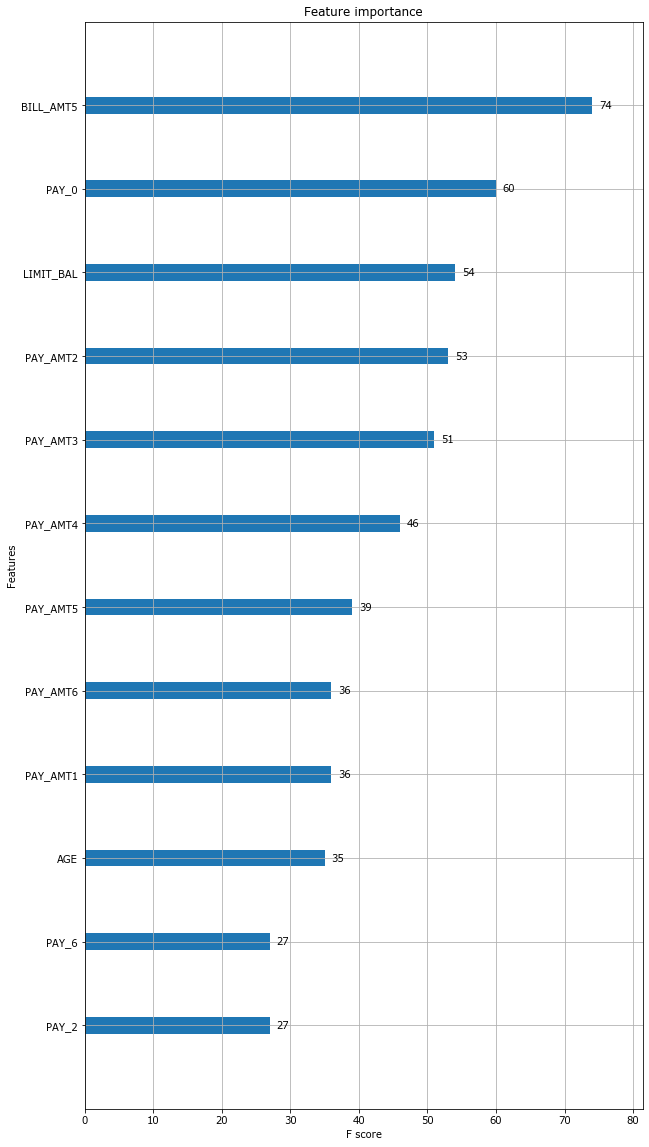

In [57]:
xgbc5 = XGBClassifier(learning_rate=0.1, max_depth=2, min_child_weight=0.15, n_estimators=180, subsample=0.5)
xgbc5.fit(X_train[cols3], y_train)
train_gini5 = roc_auc_score(y_train, xgbc5.predict_proba(X_train[cols3])[:,1])*2-1
test_gini5 = roc_auc_score(y_test, xgbc5.predict_proba(X_test[cols3])[:,1])*2-1
print(train_gini5,test_gini5)
pylab.rcParams['figure.figsize']=(10,20)
plot_importance(xgbc5)

In [58]:
from sklearn.model_selection import cross_val_score
cv_gini=((cross_val_score(xgbc5, X_train[cols3], y_train, scoring='roc_auc', cv=5))*2-1).mean()
cv_gini

0.5402250990120775

In [63]:
def tree_to_sql(tree, t):
    if tree.leave:
        return('\t' * t) + "%.8f" % tree.value
    else:
        str1 = '\t' * t + 'case when %s\n' % (tree.yes_condition())
        str2 = '\t' * t + 'then'
        str3 = '\n%s\n' % (tree_to_sql(tree.yes, t+1))
        str4 = '\t' * t + 'else\n'
        str5 = '%s\n' % (tree_to_sql(tree.no, t+1)) + '\t' * t + 'end'
        return str1 + str2 + str3 + str4 + str5

In [64]:
class node:
    def __init__(self, tree):
        if tree.find('yes=') > 0:
            self.leave = False
            self.var = (tree[tree.find("[")+1: tree.find('<')])
            self.thres = float(tree[tree.find('<')+1: tree.find(']')])
            self.missing_is_yes = (tree[tree.find('yes=')+4 : tree.find('yes=')+5])==(tree[tree.find('missing=')+8 : tree.find('missing=')+9])
            i1 = (tree[tree.find('yes=')+4 : tree.find(',')])
            i2 = (tree[tree.find('no=')+3 : tree.find(',', tree.find(',')+1)])
            tree1 = (tree[tree.find('\t'+i1+':'):tree.find('\t'+i2+':')])
            tree2 = (tree[tree.find('\t'+i2+':'):])
            if len(tree1)<3 or len(tree2)<3:
                raise
            self.yes = node(tree1)
            self.no = node(tree2)
        else:
            self.leave = True
            self.value = float(tree[tree.find('leaf=')+5:])
            if self.value is None:
                raise
    def yes_condition(self):
        return "(%s<%.8f)"%(self.var, self.thres)
    def no_condition(self):
        return "(%s>=%.8f)"%(self.var, self.thres)


In [65]:
print('\n+\n'.join([tree_to_sql(node(i),0) for i in xgbc5.get_booster().get_dump()]))

case when (PAY_0<2.00000000)
then
	case when (PAY_2<2.00000000)
	then
		-0.14096037
	else
		-0.02795699
	end
else
	case when (PAY_6<1.00000000)
	then
		0.05263158
	else
		0.10491802
	end
end
+
case when (PAY_0<2.00000000)
then
	case when (PAY_2<2.00000000)
	then
		-0.12815726
	else
		-0.02689396
	end
else
	case when (PAY_6<0.00000000)
	then
		-0.00186765
	else
		0.08046033
	end
end
+
case when (PAY_0<2.00000000)
then
	case when (PAY_2<2.00000000)
	then
		-0.11896595
	else
		-0.02705389
	end
else
	case when (PAY_6<1.00000000)
	then
		0.05244857
	else
		0.09070068
	end
end
+
case when (PAY_0<2.00000000)
then
	case when (PAY_2<2.00000000)
	then
		-0.10605437
	else
		-0.02182982
	end
else
	case when (PAY_6<1.00000000)
	then
		0.03879939
	else
		0.08411202
	end
end
+
case when (PAY_0<2.00000000)
then
	case when (PAY_AMT2<1346.00000000)
	then
		-0.06027639
	else
		-0.10840392
	end
else
	case when (PAY_2<0.00000000)
	then
		-0.05421851
	else
		0.05983026
	end
end
+
case when (PAY_0<1.00000000

In [74]:
data2['proba'] = (xgbc5.predict_proba(data2[cols3])[:,1])

In [75]:
data2['proba']

0        0.669214
1        0.362159
2        0.113526
3        0.144698
4        0.071642
           ...   
29995    0.048758
29996    0.121789
29997    0.577948
29998    0.135046
29999    0.150806
Name: proba, Length: 30000, dtype: float32

In [76]:
data2[cols3+['proba']].to_excel(r'C:\Users\Alfa\Desktop\scored_data.xlsx')

In [80]:
X_train=pd.concat([X_train, y_train], axis = 1)

In [85]:
X_train['proba'] = (xgbc5.predict_proba(X_train[cols3])[:,1])
X_train[cols3+['proba', 'target']].to_excel(r'C:\Users\Alfa\Desktop\scored_train.xlsx')

In [83]:
X_test=pd.concat([X_test, y_test], axis = 1)

In [86]:
X_test['proba'] = (xgbc5.predict_proba(X_test[cols3])[:,1])
X_test[cols3+['proba', 'target']].to_excel(r'C:\Users\Alfa\Desktop\scored_test.xlsx')